In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

In [2]:
import urllib.request
import os

# Create a directory to store the dataset
os.makedirs("celeba_dataset", exist_ok=True)

# URL to the CelebA dataset
url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip"

# Download the dataset
urllib.request.urlretrieve(url, "celeba.zip")

# Unzip the dataset
!unzip celeba.zip -d celeba_dataset

KeyboardInterrupt: 

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [4]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Flatten(),

            nn.Linear(16384, latent_size)
        )

        self.mu = nn.Linear(latent_size, latent_size)
        self.logvar = nn.Linear(latent_size, latent_size)

        self.decoder = nn.Sequential(

            nn.Linear(latent_size, 16384),
            nn.Unflatten(1, (64, 16, 16)),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(3),           
            nn.Sigmoid()
        )

    def reparemetrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return mu + eps * std

    def forward(self, x):
        x=x.to(device)
        encoded = self.encoder(x)
        mu, logvar = self.mu(encoded), self.logvar(encoded)
        z = self.reparemetrize(mu, logvar)
        x_hat = self.decoder(z)

        return x_hat, mu, logvar

torch.Size([32, 3, 128, 128])


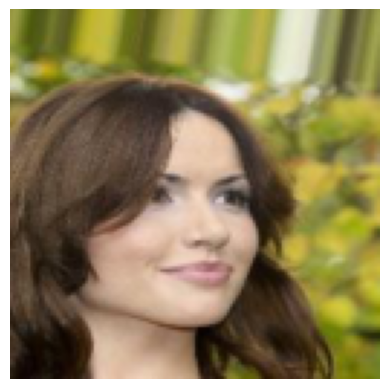

In [17]:
#creating a dataloader for the hand dataset
IMG_SIZE = 128
BATCH_SIZE = 32
LATENT_SIZE = 64
transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToTensor()])
trainset = datasets.ImageFolder(root='./celeba_dataset', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
#get subset of the dataset
trainset_5 = torch.utils.data.Subset(trainset, np.random.choice(len(trainset), int(len(trainset)/5), replace=False))
trainloader_5 = torch.utils.data.DataLoader(trainset_5, batch_size=BATCH_SIZE, shuffle=True)

print(next(iter(trainloader))[0].shape)
plt.imshow(next(iter(trainloader))[0][0].permute(1, 2, 0))
plt.axis('off')
plt.show()

In [18]:
INPUT_SIZE = 3*IMG_SIZE*IMG_SIZE
MODEL = VAE(input_size=INPUT_SIZE, latent_size=LATENT_SIZE).to(device)
print(MODEL)
summary(MODEL, (3, 128, 128), batch_size=BATCH_SIZE)

RuntimeError: MPS backend out of memory (MPS allocated: 17.89 GB, other allocations: 254.38 MB, max allowed: 18.13 GB). Tried to allocate 64.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [11]:
def generate(model, num_samples=16, latent_size=LATENT_SIZE):
    latent = torch.randn(num_samples, latent_size).to(device)
    samples = model.decoder(latent)
    samples = samples.detach().cpu()
    return samples

def plot_reconstruction(x, pred, model, num_samples=16):
    samples = generate(model, num_samples=num_samples)
    images = x.detach().cpu()
    reconstructions = pred.detach().cpu()

    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(25, 7))

    for i in range(int(x.shape[0])):
        # Display original image
        axes[0, i].imshow(images[i].permute(1,2,0))
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')

        # Display reconstruction
        axes[1, i].imshow(reconstructions[i].permute(1,2,0))
        axes[1, i].set_title(f'Recons {i+1}')
        axes[1, i].axis('off')

        
        axes[2, i].axis('off')

        # Display SAMPLES
        axes[3, i].imshow(samples[i].permute(1,2,0))
        axes[3, i].set_title(f'Sample {i+1}')
        axes[3, i].axis('off')
    plt.tight_layout()
    plt.show()

    

In [8]:
rec_loss = nn.MSELoss()
learning_rate = 3e-4
optimizer = torch.optim.Adam(MODEL.parameters(), lr=learning_rate)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [14]:
def train(model, dataloader, optimizer, epochs=1, beta=1, device=device, scheduler1=scheduler1):
    model.train()
    avg_loss = []
    full_loss = {}
    full_loss['kl'] = []
    full_loss['rec'] = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_idx, (x, _) in enumerate(dataloader):

            optimizer.zero_grad()
            x = x.to(device)
            pred, mu, logvar = model(x)

            #loss
            reconstruction_loss = rec_loss(x, pred)
            # kl_divergence_other = -0.5 * torch.mean(logvar - mu.pow(2) - logvar.exp())
            kl_divergence = -0.5 * torch.mean(1 + logvar - mu**2 - logvar.exp())
            # print(kl_divergence_other.item(), kl_divergence.item())
            loss = reconstruction_loss + beta * kl_divergence
            avg_loss.append(loss.item())
            full_loss['kl'].append(kl_divergence)
            full_loss['rec'].append(reconstruction_loss)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            #sanity checks
            if loss.item() >= 100:
                print(f"Loss: {loss.item()} || Rec_loss: {reconstruction_loss} || KL_div: {kl_divergence}")

            if batch_idx % 1000 == 0 or (batch_idx)/len(dataloader) == 1:
                print(f'Epoch: {epoch}, Batch [{batch_idx}/{len(dataloader)}], Loss: {np.mean(avg_loss):.4f}')
                print(f"Loss: {loss.item()} || Rec_loss: {reconstruction_loss} || KL_div: {kl_divergence}")
                avg_loss.clear()
                plot_reconstruction(x, pred, model)

        print(f"\nEPOCH_LOSS: {epoch_loss/(len(dataloader)*BATCH_SIZE)}\n")
        scheduler1.step()

    return epoch_loss/(len(dataloader)*BATCH_SIZE), full_loss

Epoch: 0, Batch [0/25325], Loss: 0.0714
Loss: 0.0714196264743805 || Rec_loss: 0.0629638060927391 || KL_div: 0.016911640763282776


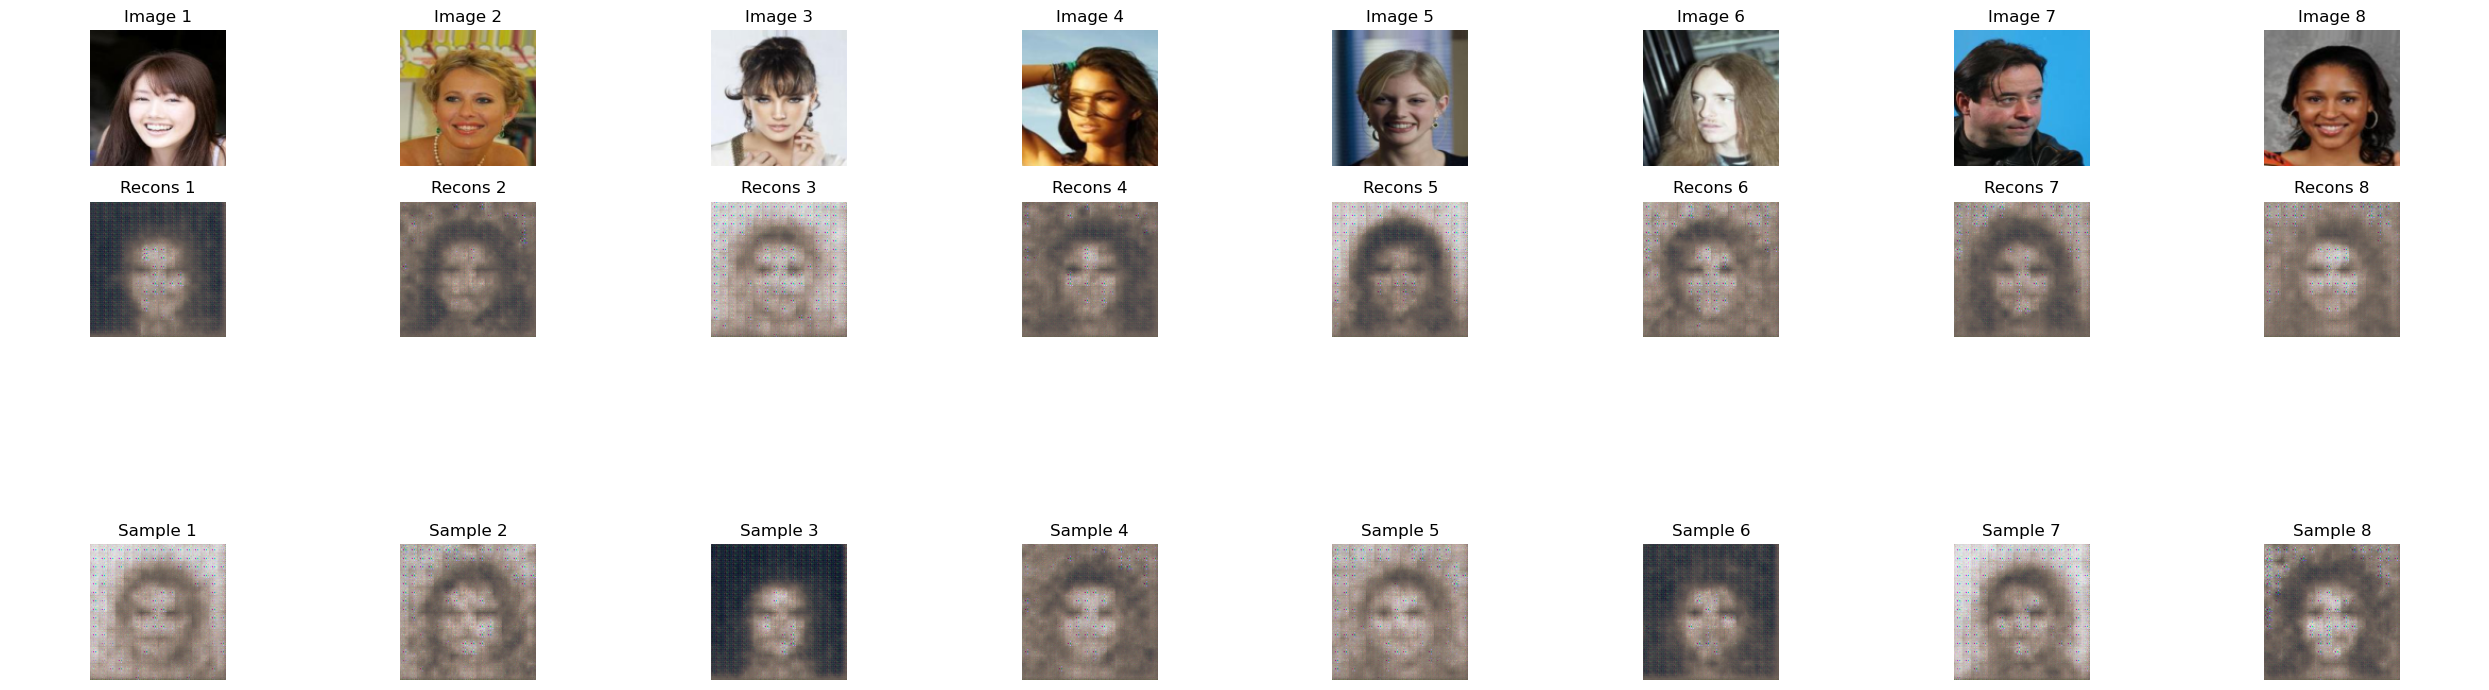

Epoch: 0, Batch [1000/25325], Loss: 0.0752
Loss: 0.06435807049274445 || Rec_loss: 0.053252846002578735 || KL_div: 0.02221044898033142


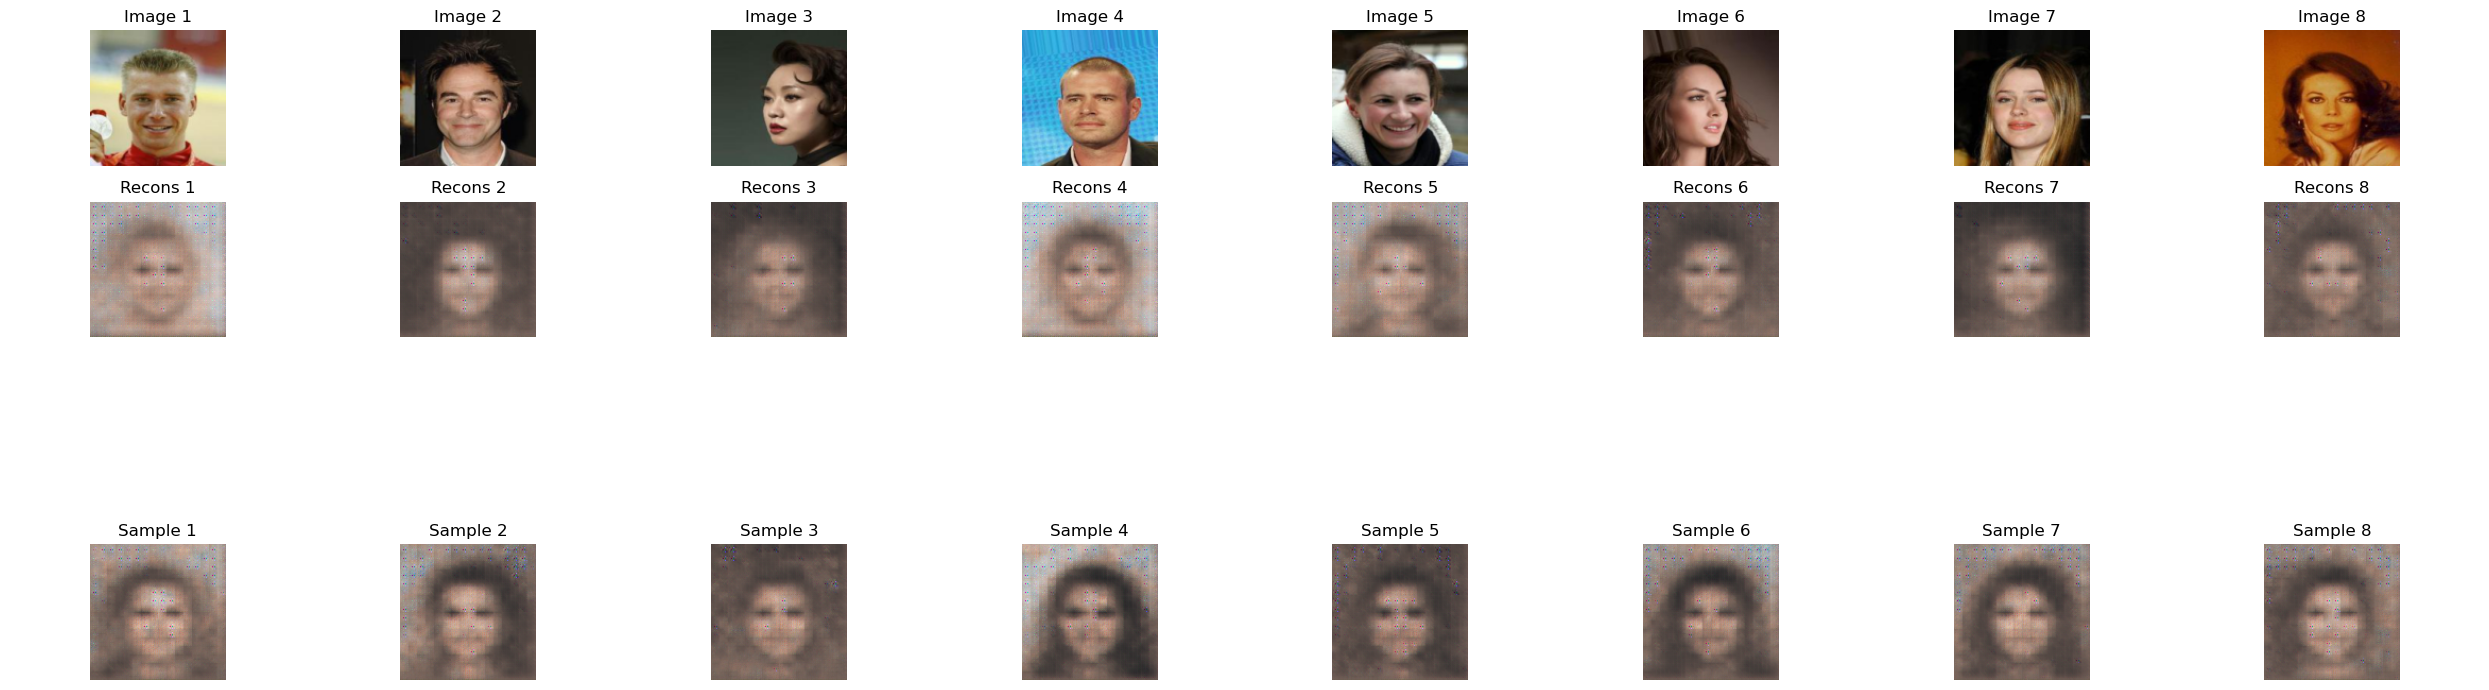

Epoch: 0, Batch [2000/25325], Loss: 0.0716
Loss: 0.0717906504869461 || Rec_loss: 0.06281280517578125 || KL_div: 0.017955690622329712


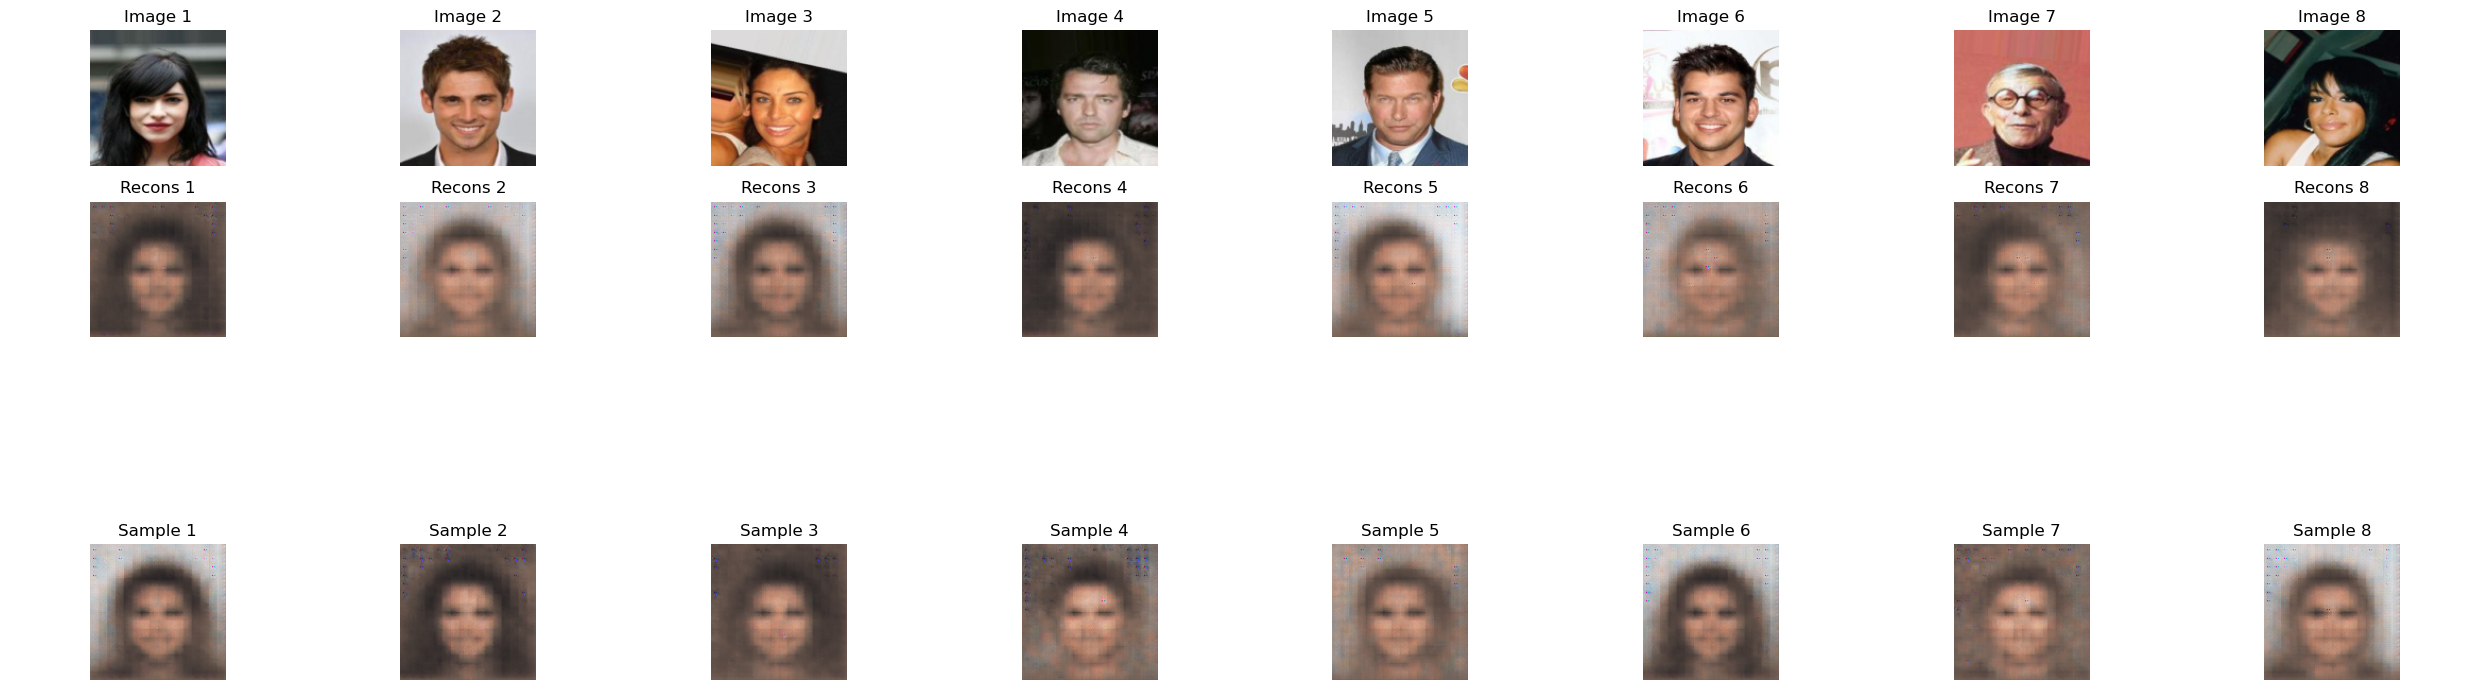

Epoch: 0, Batch [3000/25325], Loss: 0.0680
Loss: 0.07689365744590759 || Rec_loss: 0.06712259352207184 || KL_div: 0.019542120397090912


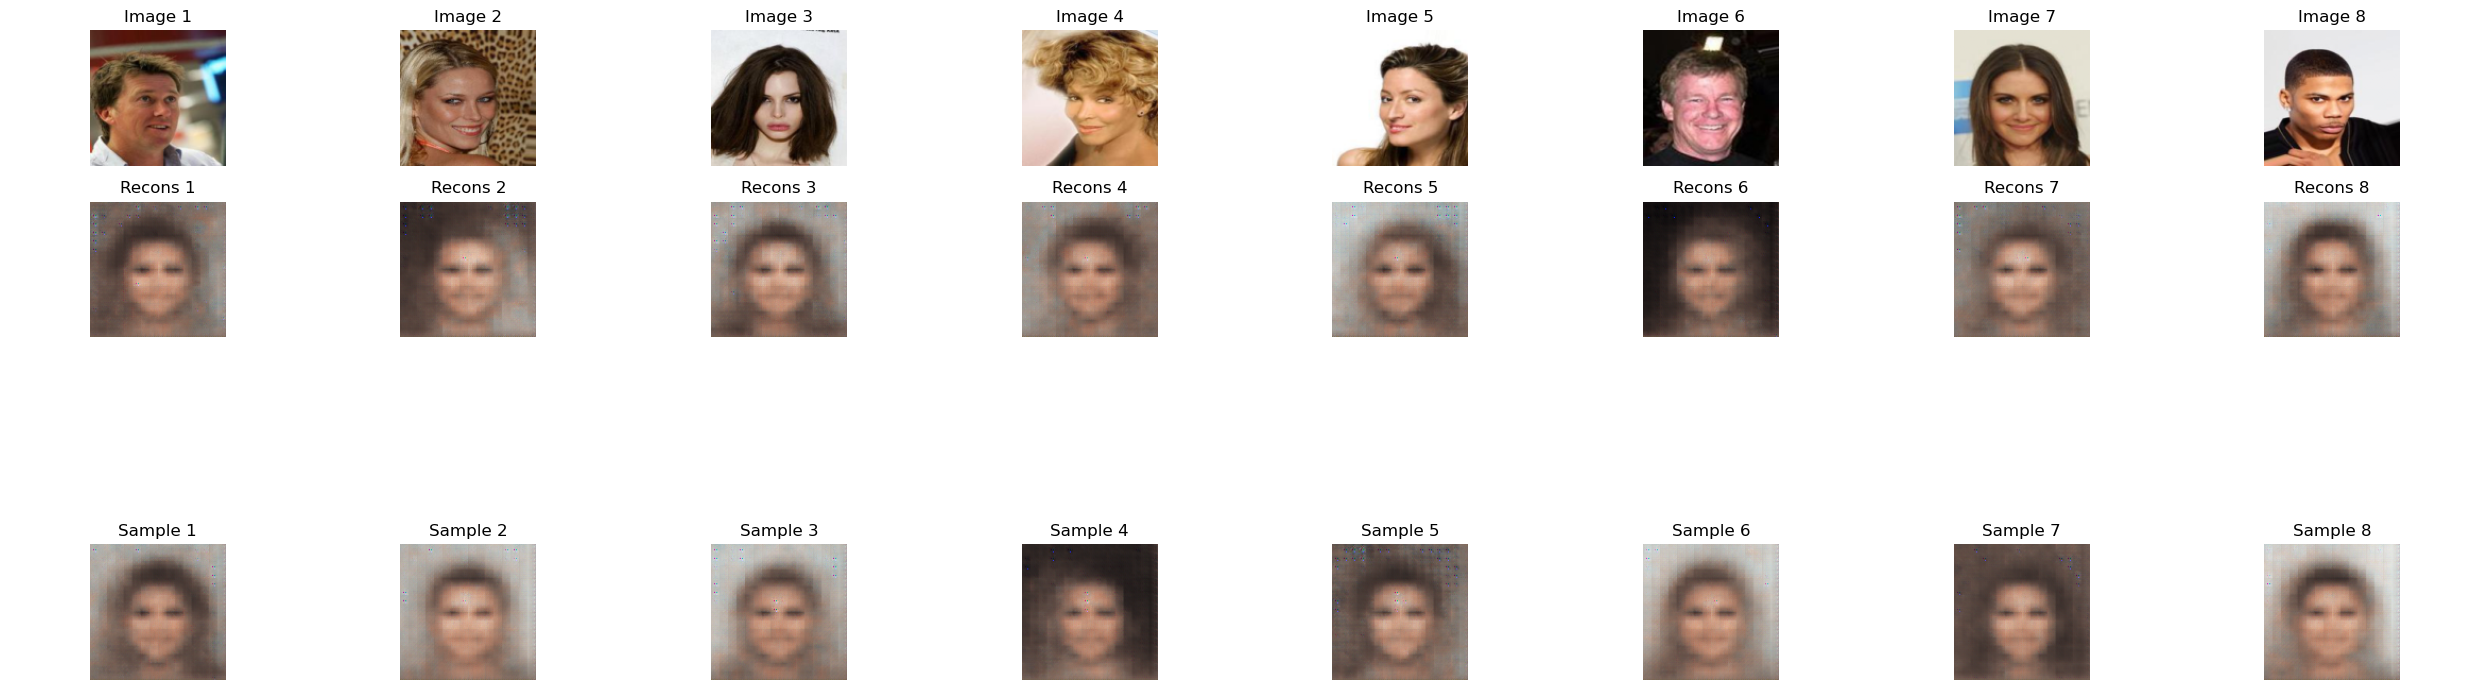

Epoch: 0, Batch [4000/25325], Loss: 0.0667
Loss: 0.0615011528134346 || Rec_loss: 0.05061305686831474 || KL_div: 0.021776190027594566


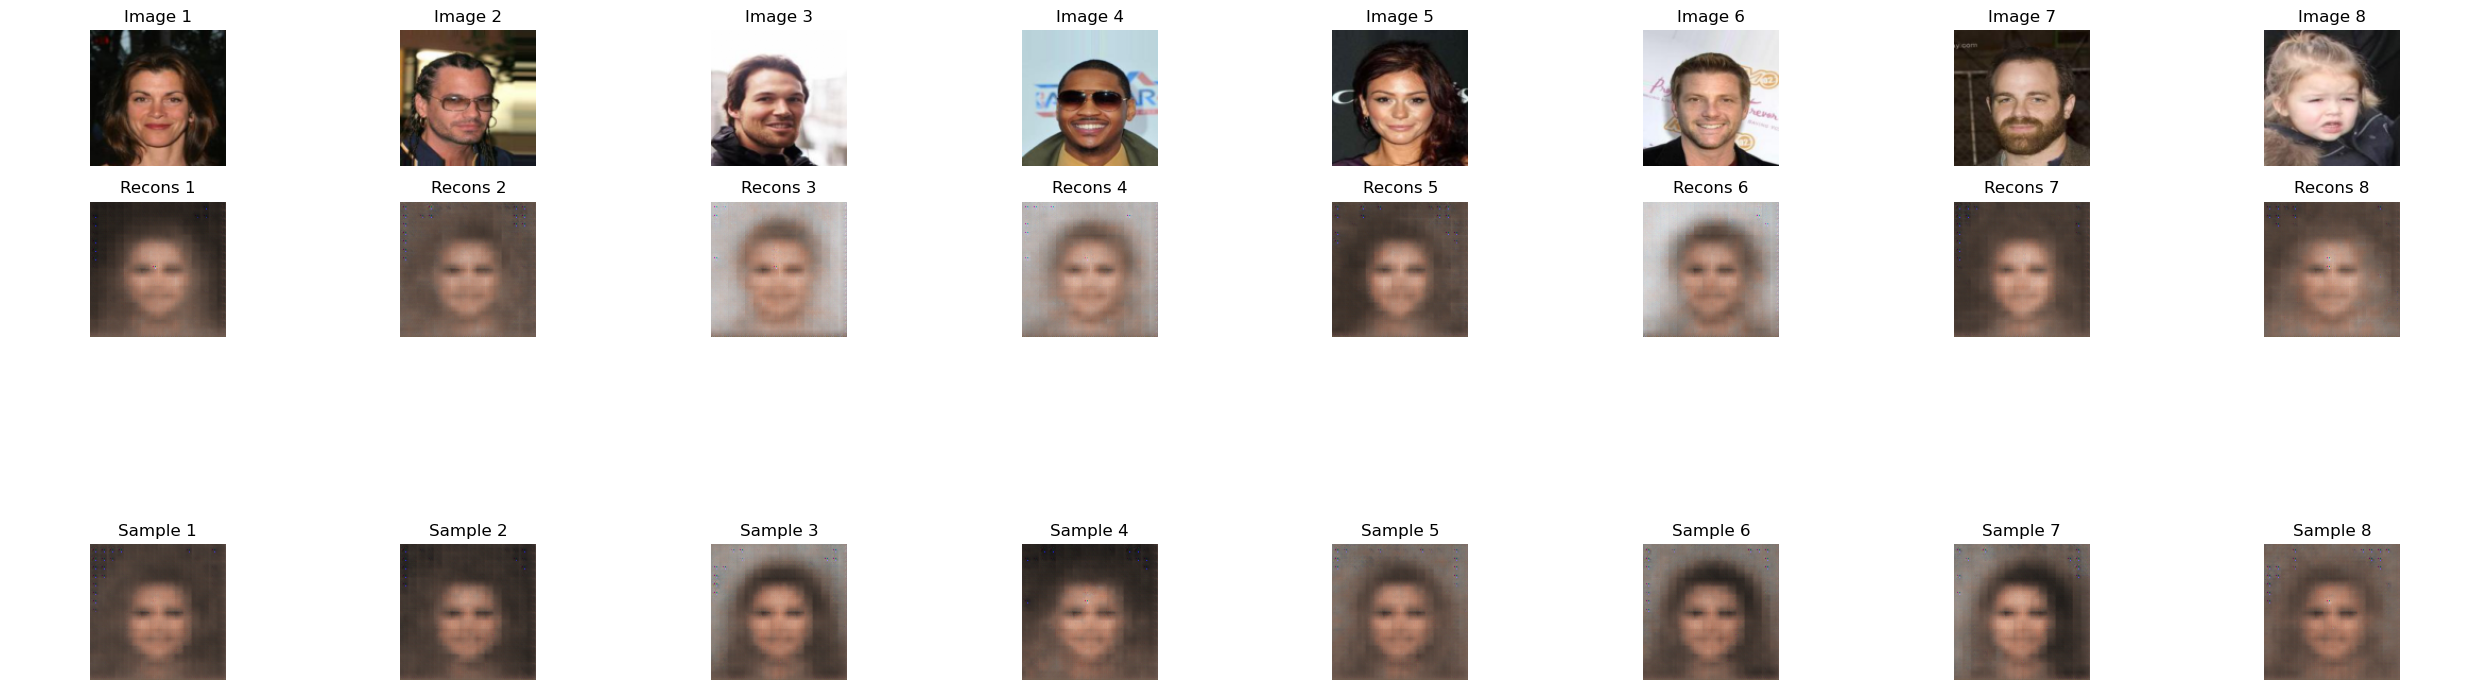

RuntimeError: MPS backend out of memory (MPS allocated: 17.89 GB, other allocations: 263.76 MB, max allowed: 18.13 GB). Tried to allocate 1.75 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [15]:
epoch_loss, full_loss = train(MODEL, trainloader, optimizer, epochs=1, beta=0.5, device=device)